In [1]:
"""
###############################################################################################
    10-Armed Testbed (Reinforcement Learning: An Introduction, Sutton, Barto, fig 2.2)
    Created by Youn-Hee Han 12/27/2019, last update 12/27/2019

    한글 폰트 설치 참고 사이트: https://programmers.co.kr/learn/courses/21/lessons/950
###############################################################################################
"""
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib as mpl

plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.size"] = 12
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
################################################################
# 상태와 행동 및 문제에 대한 설정 규칙을 포함하는 테스트베드 클래스
class Testbed(object):
    # Constructor
    def __init__(self, num_arms, mean, std):
        # 암의 개수
        self.num_arms = num_arms

        # 참 가치와 보상 값 설정을 위한 정규 분포 파라미터
        self.mean = mean  # 평균
        self.std = std  # 표준 편차

        self.real_values = None  # 행동에 대한 Value를 저장하는 배열
        self.optimal_action = 0  # 최적 Value를 저장하는 변수
        self.reset()

    # 매 시행시 맨 처음 불리우는 Reset 함수
    def reset(self):
        # 에이전트에게는 알려주지 않는 참 가치 값: 정규 분포(평균: 0, 표준 편차: 1)를 통해 샘플링
        self.real_values = np.random.normal(self.mean, self.std, self.num_arms)

        # 참 가치값이 가장 큰 행동 추출
        self.optimal_action = np.argmax(self.real_values)

    def __str__(self):
        msg = "참 가치: {0}, 최적 행동: {1}".format(
            self.real_values,
            self.optimal_action
        )
        return msg

In [3]:
################################################################
# 테스트베드 위에서 환경과 상호작용하는 에이전트
class Agent(object):
    def __init__(self, num_arms, epsilon=0.0):
        self.num_arms = num_arms    # 밴딧이 지닌 암의 개수
        self.epsilon = epsilon      # Epsilon 값

        self.count_of_actions = np.zeros(num_arms)  # 행동별 수행 횟수
        self.sum_of_reward = np.zeros(num_arms)     # 행동별 누적 보상
        self.value_estimates = np.zeros(num_arms)   # 행동별 추정 가치

    # 그래프의 범주에 활용할 에이전트 전략 이름 문자열 반환
    def __str__(self):
        if self.epsilon == 0:
            return "Greedy"
        else:
            return "Epsilon Greedy [Epsilon = {0}]".format(self.epsilon)

    # Epsilon 탐욕적 선택 방법으로 행동 선택
    # 만약 Epsilon 값이 0이면 단순한 탐욕적 방법으로 행동이 선택됨
    def action(self):
        rand_prob = np.random.random()  # 0 ~ 1 사이의 임의의 값이 샘플링됨
        if rand_prob < self.epsilon:
            selected_action = np.random.choice(self.num_arms)  # 임의의 행동 선택

        # Greedy Method
        else:
            # 최고의 추정 가치에 해당하는 행동 인덱스를 가져옴
            best_action_idx_list = np.argwhere(self.value_estimates == np.amax(self.value_estimates)).flatten().tolist()

            if len(best_action_idx_list) == 1:
                # 추정하는 최대 가치에 해당하는 행동이 1개이면 그 행동을 선택
                selected_action = best_action_idx_list[0]
            else:
                # 추정하는 최대 가치에 해당하는 행동이 여러개이면 그러한 중 임의의 행동을 선택
                selected_action = np.random.choice(best_action_idx_list)

        return selected_action

    # 받아낸 보상 값을 통하여 추정 가치 갱신
    def update(self, selected_action, reward):
        # Add 1 to the number of action taken in step

        self.count_of_actions[selected_action] += 1     # 행동 수행 횟수 1 증가
        self.sum_of_reward[selected_action] += reward   # 보상을 누적함

        # 행동의 추정 가치 갱신
        self.value_estimates[selected_action] = self.sum_of_reward[selected_action] / self.count_of_actions[selected_action]

    # 에이전트가 관리하는 각 변수 초기화
    def reset(self):
        self.count_of_actions[:] = 0    # 행동별 수행 횟수 저장
        self.sum_of_reward[:] = 0       # 행동별 누적 보상
        self.value_estimates[:] = 0     # 행동별 추정 가치

In [4]:
################################################################
# 에이전트가 상호작용하는 환경 클래스
class Environment(object):
    def __init__(self, testbed, agents, max_time_steps, num_iterations):
        self.testbed = testbed
        self.agents = agents

        self.max_time_steps = max_time_steps
        self.num_iterations = num_iterations

    # 테스트 수행
    def play(self):
        # 각 에이전트 및 각 타입 스텝별로 누적 보상을 저장하는 배열
        scores = np.zeros((self.max_time_steps, len(self.agents)))

        # 각 에이전트 및 각 타입 스텝별로 최적 행동 비율을 저장하는 배열
        optimal_actions = np.zeros((self.max_time_steps, len(self.agents)))

        # 각 시행별로 루프를 수행
        for iteration in range(self.num_iterations):
            # 매 100번의 시행마다 출력 시행 횟수 출력
            if (iteration % 100) == 0:
                print("Completed Iterations: {0}".format(iteration))

            # 테스트베드와 모든 에이전트 초기화
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()

            # 각 타입 스텝별로 루프를 수행
            for time_step in range(self.max_time_steps):
                for agent_idx, agent in enumerate(self.agents):
                    selected_action = agent.action()

                    # 보상은 정규 분포(평균: q_*(at), 표준편차: 1)로 부터 샘플링함
                    reward = np.random.normal(self.testbed.real_values[selected_action], scale=1)

                    # 에이전트의 추정 가치 갱신
                    agent.update(selected_action, reward)

                    # 누적 보상 --> 스코어 (그래프 1에 표현됨)
                    scores[time_step, agent_idx] += reward

                    # 테스트 베드에 설정된 에이전트에게 알려지지 않은 최적 행동과 동일한 행동을 수행하였는지 체크 (그래프 2에 표현됨)
                    if selected_action == self.testbed.optimal_action:
                        optimal_actions[time_step, agent_idx] += 1.0

        score_avg = scores / self.num_iterations
        optimal_action_rate = optimal_actions / self.num_iterations

        return score_avg, optimal_action_rate

In [5]:
def main():
    start_time = time.time()  # 실험 시작 시간 저장
    num_arms = 10  # 밴딧의 암 개수
    num_iterations = 3000  # 총 시행 수
    max_time_steps = 2000  # 한번의 시행 내 최대 타임 스텝 수

    testbed = Testbed(num_arms=num_arms, mean=0, std=1)
    agents = [
        Agent(num_arms=num_arms),
        Agent(num_arms=num_arms, epsilon=0.2),
        Agent(num_arms=num_arms, epsilon=0.1),
        Agent(num_arms=num_arms, epsilon=0.01)
    ]
    environment = Environment(
        testbed=testbed,
        agents=agents,
        max_time_steps=max_time_steps,
        num_iterations=num_iterations
    )

    # 테스트 수행
    print("Running...")
    print(testbed)

    score_avg, optimal_action_rate = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))

    line_style = ['-', '--', '-.', ':']

    # Graph 1 - 타입 스텝에 따라 변하는 평균 누적 보상(스코어)
    plt.title("10-Armed TestBed - 평균 누적 보상")
    for idx, agent in enumerate(agents):
        plt.plot(
            [x + 5 - 1 for x in range(0, 1000, 5)],
            score_avg[::5, idx],
            linestyle=line_style[idx],
            label=str(agent)
        )
    plt.ylabel('평균 누적 보상')
    plt.xlabel('타임 스텝')
    plt.legend(agents, loc=4)
    plt.show()

    # Graph 1 - 타입 스텝에 따라 변하는 최적 행동 비율
    plt.title("10-Armed TestBed - 최적 행동 비율(%)")
    for idx, agent in enumerate(agents):
        plt.plot(
            [x + 5 - 1 for x in range(0, 1000, 5)],
            optimal_action_rate[::5, idx] * 100,
            linestyle=line_style[idx],
            label=str(agent)
        )
    plt.ylim(0, 100)
    plt.ylabel('최적 행동 비율(%)')
    plt.xlabel('타임 스텝')
    plt.legend(agents, loc=4)
    plt.show()

Running...
참 가치: [ 0.53517481  0.5363987   0.51616996 -1.89320967  0.37205001 -0.27753909
 -0.29095497  1.46915529 -0.53454613 -1.54140776], 최적 행동: 7
Completed Iterations: 0
Completed Iterations: 100
Completed Iterations: 200
Completed Iterations: 300
Completed Iterations: 400
Completed Iterations: 500
Completed Iterations: 600
Completed Iterations: 700
Completed Iterations: 800
Completed Iterations: 900
Completed Iterations: 1000
Completed Iterations: 1100
Completed Iterations: 1200
Completed Iterations: 1300
Completed Iterations: 1400
Completed Iterations: 1500
Completed Iterations: 1600
Completed Iterations: 1700
Completed Iterations: 1800
Completed Iterations: 1900
Completed Iterations: 2000
Completed Iterations: 2100
Completed Iterations: 2200
Completed Iterations: 2300
Completed Iterations: 2400
Completed Iterations: 2500
Completed Iterations: 2600
Completed Iterations: 2700
Completed Iterations: 2800
Completed Iterations: 2900
Execution time: 260.3293137550354 seconds


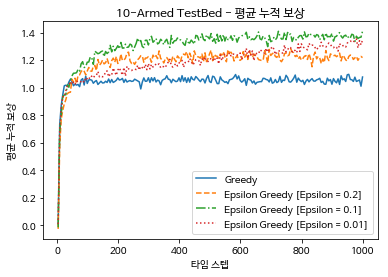

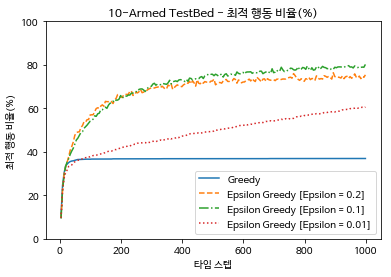

In [6]:
if __name__ == "__main__":
    main()
